EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nbformat

import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  # or MinMaxScaler


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import pgeocode
import folium
import plotly.express as px
import plotly.graph_objects as go


In [2]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv("realtor-data.zip.csv")

In [4]:
df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [5]:
print("Shape of dataset:", df.shape)
display(df.head())
display(df.info())
display(df.describe())


Shape of dataset: (2226382, 12)


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


None

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2.221849e+06,2.224841e+06,1.745065e+06,1.714611e+06,1.900793e+06,2.215516e+06,2.226083e+06,1.657898e+06
mean,5.293989e+04,5.241955e+05,3.275841e+00,2.496440e+00,1.522303e+01,1.012325e+06,5.218668e+04,2.714471e+03
std,3.064275e+04,2.138893e+06,1.567274e+00,1.652573e+00,7.628238e+02,5.837635e+05,2.895408e+04,8.081635e+05
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,2.386100e+04,1.650000e+05,3.000000e+00,2.000000e+00,1.500000e-01,5.063128e+05,2.961700e+04,1.300000e+03
50%,5.288400e+04,3.250000e+05,3.000000e+00,2.000000e+00,2.600000e-01,1.012766e+06,4.838200e+04,1.760000e+03
75%,7.918300e+04,5.500000e+05,4.000000e+00,3.000000e+00,9.800000e-01,1.521173e+06,7.807000e+04,2.413000e+03
max,1.101420e+05,2.147484e+09,4.730000e+02,8.300000e+02,1.000000e+05,2.001357e+06,9.999900e+04,1.040400e+09


Missing Value Summary

In [6]:
missing_summary = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing_summary)


Missing values per column:
prev_sold_date    734297
house_size        568484
bath              511771
bed               481317
acre_lot          325589
street             10866
brokered_by         4533
price               1541
city                1407
zip_code             299
state                  8
status                 0
dtype: int64


In [7]:
# Removing unnecessary columns
df_clean = df.drop(['prev_sold_date', 'status', 'street', 'brokered_by'], axis=1)


In [8]:

df_clean = df.dropna()

df_clean.shape


(1084909, 12)

In [9]:
# prompt: Remove GUAM, DISTRICT OF COLUMBIA, NEW BRUNSWICK, PUERTO RICO, and VIRGIN ISLANDS from the state column

df_clean = df_clean[~df_clean['state'].isin(['GUAM', 'DISTRICT OF COLUMBIA', 'NEW BRUNSWICK', 'PUERTO RICO', 'VIRGIN ISLANDS'])]


In [10]:
def remove_outliers(df, columns, threshold=1.5):
    clean_df = df.copy()
    for col in columns:
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        clean_df = clean_df[(clean_df[col] >= lower_bound) & (clean_df[col] <= upper_bound)]
    return clean_df

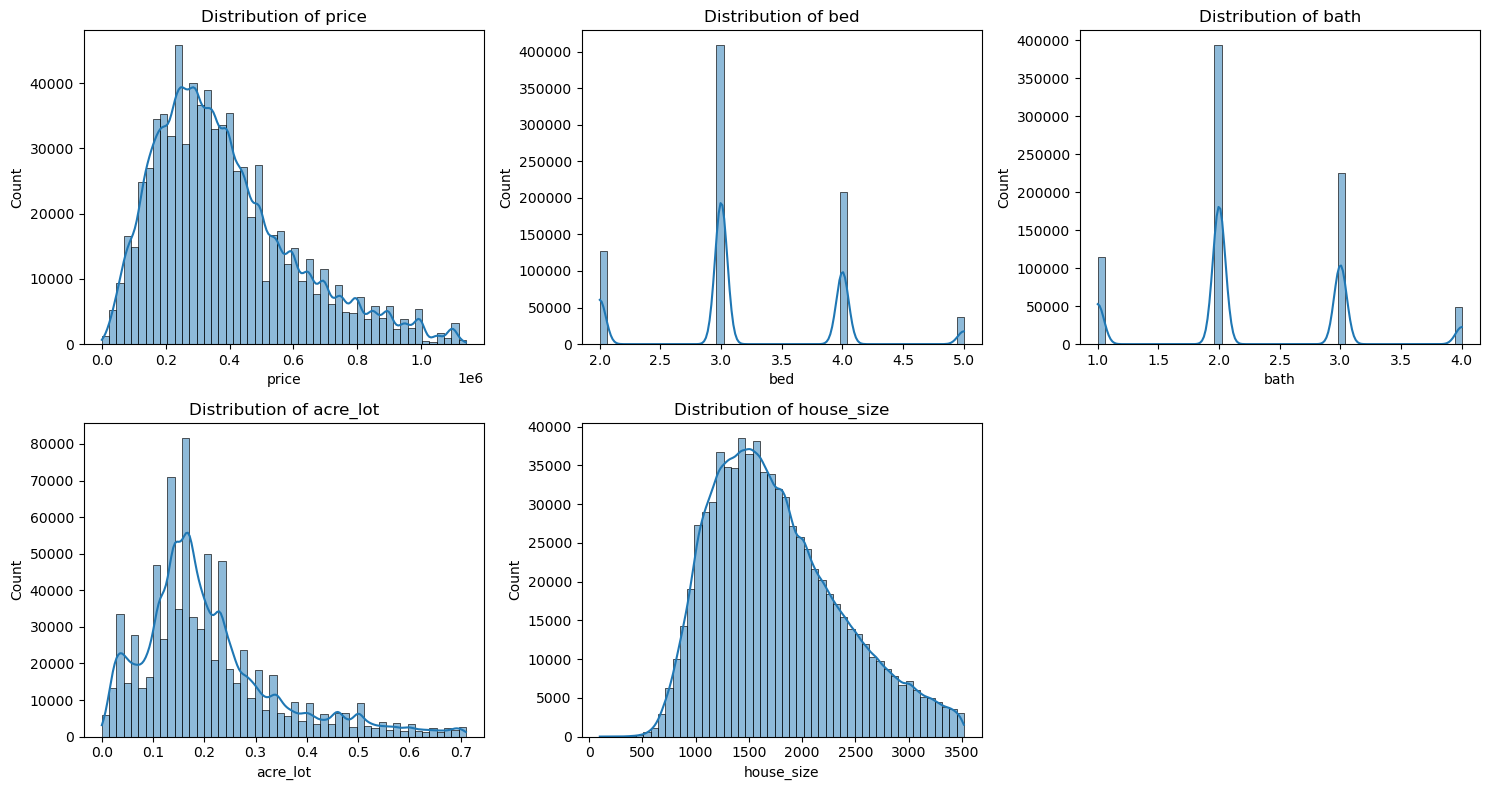

In [11]:
numeric_cols = ['price', 'bed', 'bath', 'acre_lot', 'house_size']
df_clean = remove_outliers(df_clean, numeric_cols)
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_clean[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

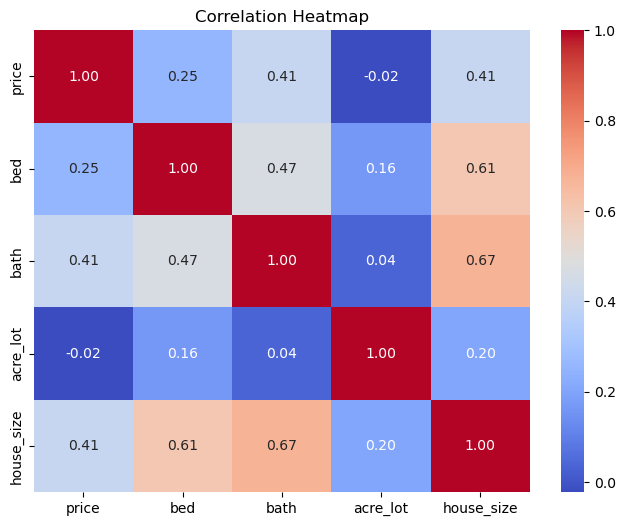

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_clean[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

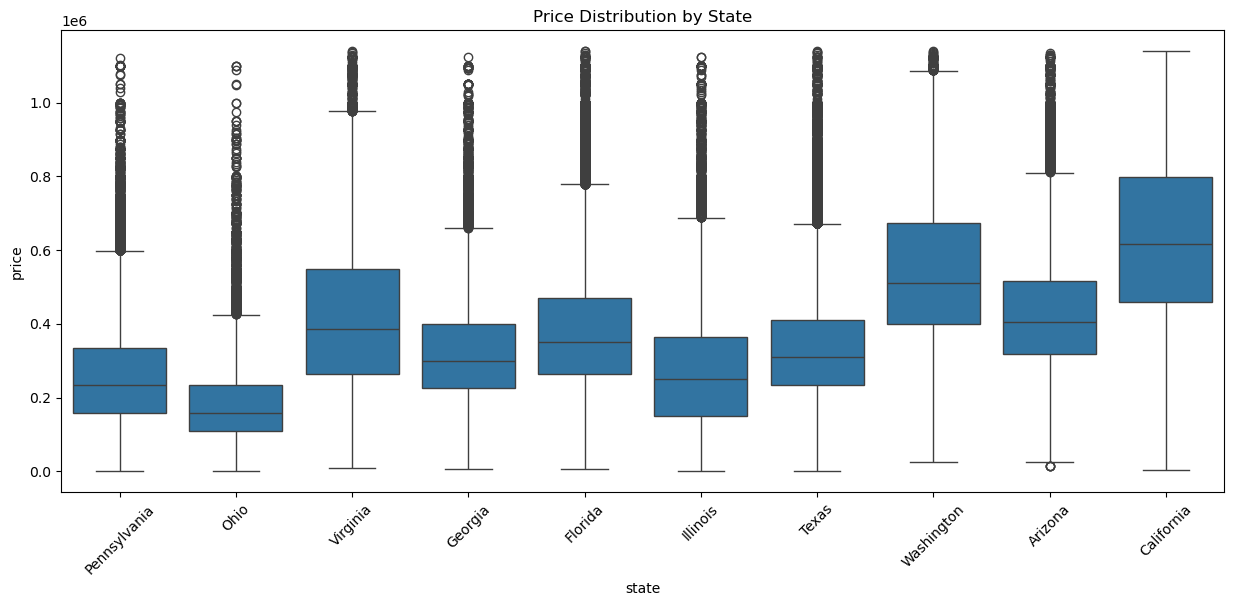

In [13]:
plt.figure(figsize=(15, 6))
top_states = df_clean['state'].value_counts().head(10).index  # Top 10 states with most listings
sns.boxplot(x=df_clean[df_clean['state'].isin(top_states)]['state'], y=df_clean['price'])
plt.xticks(rotation=45)
plt.title("Price Distribution by State")
plt.show()

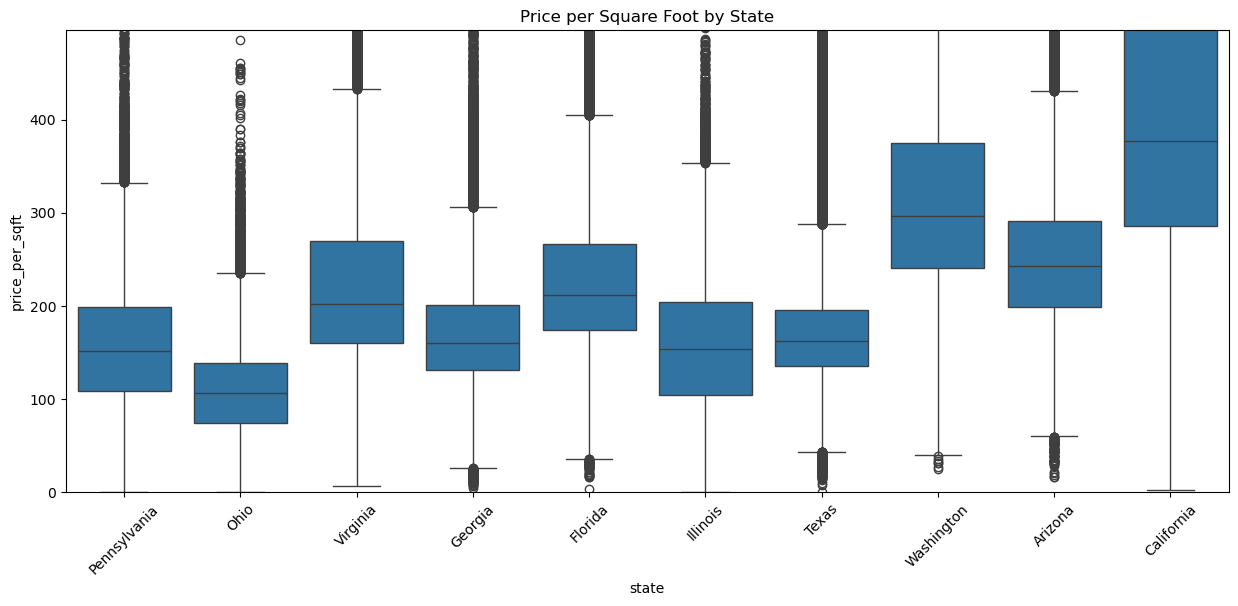

In [14]:
df_clean["price_per_sqft"] = df_clean["price"] / df_clean["house_size"]
plt.figure(figsize=(15, 6))
sns.boxplot(x=df_clean[df_clean['state'].isin(top_states)]['state'], y=df_clean["price_per_sqft"])
plt.xticks(rotation=45)
plt.title("Price per Square Foot by State")
plt.ylim(0, df_clean["price_per_sqft"].quantile(0.95))  # Remove extreme outliers
plt.show()

In [15]:
df_clean['state'] = df_clean['state'].str.upper().str.strip()

state_prices = df_clean.groupby("state")["price"].median().reset_index()

us_states = {
    'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AR', 'CALIFORNIA': 'CA',
    'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE', 'FLORIDA': 'FL', 'GEORGIA': 'GA',
    'HAWAII': 'HI', 'IDAHO': 'ID', 'ILLINOIS': 'IL', 'INDIANA': 'IN', 'IOWA': 'IA', 'KANSAS': 'KS',
    'KENTUCKY': 'KY', 'LOUISIANA': 'LA', 'MAINE': 'ME', 'MARYLAND': 'MD', 'MASSACHUSETTS': 'MA',
    'MICHIGAN': 'MI', 'MINNESOTA': 'MN', 'MISSISSIPPI': 'MS', 'MISSOURI': 'MO', 'MONTANA': 'MT',
    'NEBRASKA': 'NE', 'NEVADA': 'NV', 'NEW HAMPSHIRE': 'NH', 'NEW JERSEY': 'NJ', 'NEW MEXICO': 'NM',
    'NEW YORK': 'NY', 'NORTH CAROLINA': 'NC', 'NORTH DAKOTA': 'ND', 'OHIO': 'OH', 'OKLAHOMA': 'OK',
    'OREGON': 'OR', 'PENNSYLVANIA': 'PA', 'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC',
    'SOUTH DAKOTA': 'SD', 'TENNESSEE': 'TN', 'TEXAS': 'TX', 'UTAH': 'UT', 'VERMONT': 'VT',
    'VIRGINIA': 'VA', 'WASHINGTON': 'WA', 'WEST VIRGINIA': 'WV', 'WISCONSIN': 'WI', 'WYOMING': 'WY'
}

state_prices["state_abbr"] = state_prices["state"].map(us_states)

fig = px.choropleth(
    state_prices,
    locations="state_abbr",
    locationmode="USA-states",
    color="price",
    hover_name="state",
    title="Median House Price by State",
    color_continuous_scale="Blues",
    scope="usa"
)
state_positions = {
    'AL': (32.806671, -86.791130), 'AK': (61.370716, -152.404419), 'AZ': (33.729759, -111.431221),
    'AR': (34.969704, -92.373123), 'CA': (36.116203, -119.681564), 'CO': (39.059811, -105.311104),
    'CT': (41.597782, -72.755371), 'DE': (39.318523, -75.507141), 'FL': (27.766279, -81.686783),
    'GA': (33.040619, -83.643074), 'HI': (20.796783, -156.331924), 'ID': (44.240459, -114.478828),
    'IL': (40.349457, -88.986137), 'IN': (39.849426, -86.258278), 'IA': (42.011539, -93.210526),
    'KS': (38.526600, -96.726486), 'KY': (37.668140, -84.670067), 'LA': (31.169546, -91.867805),
    'ME': (44.693947, -69.381927), 'MD': (39.063946, -76.802101), 'MA': (42.230171, -71.530106),
    'MI': (43.326618, -84.536095), 'MN': (45.694454, -93.900192), 'MS': (32.741646, -89.678696),
    'MO': (38.456085, -92.288368), 'MT': (46.921925, -110.454353), 'NE': (41.125370, -98.268082),
    'NV': (38.313515, -117.055374), 'NH': (43.452492, -71.563896), 'NJ': (40.298904, -74.521011),
    'NM': (34.840515, -106.248482), 'NY': (42.165726, -74.948051), 'NC': (35.630066, -79.806419),
    'ND': (47.528912, -99.784012), 'OH': (40.388783, -82.764915), 'OK': (35.565342, -96.928917),
    'OR': (44.572021, -122.070938), 'PA': (40.590752, -77.209755), 'RI': (41.680893, -71.511780),
    'SC': (33.856892, -80.945007), 'SD': (44.299782, -99.438828), 'TN': (35.747845, -86.692345),
    'TX': (31.054487, -97.563461), 'UT': (40.150032, -111.862434), 'VT': (44.045876, -72.710686),
    'VA': (37.769337, -78.169968), 'WA': (47.400902, -121.490494), 'WV': (38.491226, -80.954460),
    'WI': (44.268543, -89.616508), 'WY': (42.755966, -107.302490)
}

# Add state abbreviations as annotations on the map
for state, (lat, lon) in state_positions.items():
    fig.add_trace(
        go.Scattergeo(
            locationmode="USA-states",
            lon=[lon],
            lat=[lat],
            text=[state],
            mode="text",
            showlegend=False
        )
    )
fig.show()

In [16]:
state_prices

,state,price,state_abbr
0,ALABAMA,224900.0,AL
1,ALASKA,425000.0,AK
2,ARIZONA,404925.0,AZ
3,ARKANSAS,240000.0,AR
4,CALIFORNIA,616900.0,CA
5,COLORADO,490298.0,CO
6,CONNECTICUT,295000.0,CT
7,DELAWARE,309000.0,DE
8,DISTRICT OF COLUMBIA,700000.0,NaN
9,FLORIDA,350000.0,FL


# Machine Learning Algorithms

### Data Preparation

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ----------------------------------------
# 1. Load data
# ----------------------------------------
df = pd.read_csv("realtor-data.zip.csv")

# ----------------------------------------
# 2. Drop unnecessary columns
# ----------------------------------------
df_clean = df.drop(['prev_sold_date', 'status', 'street', 'brokered_by'], axis=1)

# ----------------------------------------
# 3. Drop rows with missing values
# ----------------------------------------
df_clean = df_clean.dropna()

# ----------------------------------------
# 4. Filter out U.S. territories
# ----------------------------------------
excluded_states = ['GUAM', 'DISTRICT OF COLUMBIA', 'NEW BRUNSWICK', 'PUERTO RICO', 'VIRGIN ISLANDS']
df_clean = df_clean[~df_clean['state'].isin(excluded_states)]

# ----------------------------------------
# 5. Remove outliers (assuming function is defined)
def remove_outliers(df, columns, threshold=1.5):
    clean_df = df.copy()
    for col in columns:
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        clean_df = clean_df[(clean_df[col] >= lower_bound) & (clean_df[col] <= upper_bound)]
    return clean_df

numeric_cols = ['price', 'bed', 'bath', 'acre_lot', 'zip_code', 'house_size']
df_clean = remove_outliers(df_clean, numeric_cols)

# ----------------------------------------
# 6. Target encode city and state
# ----------------------------------------
city_means = df_clean.groupby("city")["price"].mean()
state_means = df_clean.groupby("state")["price"].mean()

df_clean["city_encoded"] = df_clean["city"].map(city_means)
df_clean["state_encoded"] = df_clean["state"].map(state_means)

# Drop original categorical columns
df_clean = df_clean.drop(columns=["city", "state"])

# ----------------------------------------
# 7. Split into features (X) and target (y)
# ----------------------------------------
X = df_clean.drop(columns=["price"])  # Features
y = df_clean["price"]                 # Target

# ----------------------------------------
# 8. Identify numeric features for scaling
# ----------------------------------------
numerical_features = ['bed', 'bath', 'acre_lot', 'house_size', 'zip_code', 'city_encoded', 'state_encoded']

# ----------------------------------------
# 9. Create scaling pipeline
# ----------------------------------------
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor)
])

X_transformed = pipeline.fit_transform(X)


In [18]:
X_transformed_df = pd.DataFrame(X_transformed, columns=numerical_features)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.3, random_state=42)


### Model Training

In [20]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [21]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Model Evaluation

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE       : {rmse:.2f}")
    print(f"  MSE        : {mse:.2f}")
    print(f"  R-squared  : {r2:.4f}")
    
    return y_pred, mse, r2

# ---- Run Evaluation ----
y_pred_rf, mse_rf, r2_rf = evaluate_model(rf_model, X_test, y_test, "Random Forest")
y_pred_xgb, mse_xgb, r2_xgb = evaluate_model(xgb_model, X_test, y_test, "XGBoost")




Random Forest Performance:
  RMSE       : 83644.80
  MSE        : 6996453039.38
  R-squared  : 0.8523

XGBoost Performance:
  RMSE       : 95875.25
  MSE        : 9192063612.32
  R-squared  : 0.8060


In [ ]:
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)
shap.summary_plot(shap_values_rf, X_test)

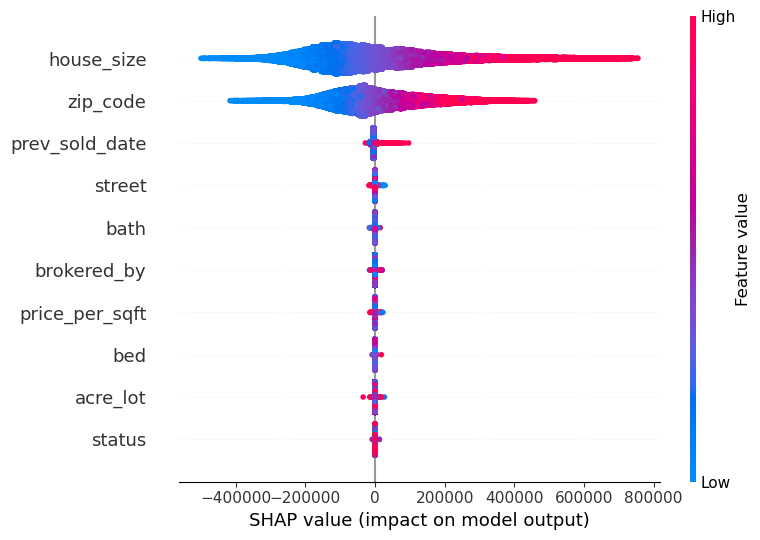

In [ ]:
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test)